In [1]:
!nvidia-smi

Tue Jan 25 10:48:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone 'https://github.com/YSdoubleM/Yooninahong.git'

Cloning into 'Yooninahong'...
remote: Enumerating objects: 6418, done.
remote: Counting objects: 100% (6418/6418), done.
remote: Compressing objects: 100% (3115/3115), done.
remote: Total 6418 (delta 91), reused 6381 (delta 60), pack-reused 0
Receiving objects: 100% (6418/6418), 271.17 MiB | 35.37 MiB/s, done.
Resolving deltas: 100% (91/91), done.
Checking out files: 100% (6876/6876), done.


In [3]:
import pandas as pd

df = pd.read_csv('/content/Yooninahong/description/captionTrain.csv')
df

,sentence
0,사람이 다가오고 있습니다
1,사람과 자전거가 다가오고 있습니다
2,자전거와 사람이 다가오고 있습니다
3,사람과 자전거가 있습니다
4,자전거와 사람이 있습니다
...,...
95,자전거가 놓여 있고 사람이 걸어갑니다
96,전동킥보드가 놓여 있고 사람이 걸어갑니다
97,오토바이가 놓여 있고 사람이 다가옵니다
98,자전거가 놓여 있고 사람이 다가옵니다


In [4]:
vocab = set()
for sent in df['sentence']:
  for token in sent.split():
    if token in vocab:
      continue
    else:
      vocab.add(token)
vocab.add('<EOS>')
print('고유 어절 수: {}개'.format(len(vocab)))

고유 어절 수: 63개


In [5]:
word2id = {'[PAD]': 0, '[UNK]': 1}
for w in vocab:
  word2id[w] = len(word2id)

In [6]:
for sent in df.head()['sentence']:
  print(sent, '<EOS>')
  print([word2id[w] for w in sent.split() + ['<EOS>']])

사람이 다가오고 있습니다 <EOS>
[52, 33, 54, 50]
사람과 자전거가 다가오고 있습니다 <EOS>
[64, 44, 33, 54, 50]
자전거와 사람이 다가오고 있습니다 <EOS>
[19, 52, 33, 54, 50]
사람과 자전거가 있습니다 <EOS>
[64, 44, 54, 50]
자전거와 사람이 있습니다 <EOS>
[19, 52, 54, 50]


In [7]:
import numpy as np

word2id_list = []
for sent in df['sentence']:
  tmp = np.array([word2id[w] for w in sent.split() + ['<EOS>']])
  word2id_list.append(tmp)

In [8]:
print(word2id_list[0])
for num in word2id_list[0]:
  for word, id in word2id.items():
    if id == num:
      print(word, end=' ')

[52 33 54 50]
사람이 다가오고 있습니다 <EOS> 

In [9]:
seq_list = []
for comment in word2id_list:
  for i in range(1, len(comment)+1):
    seq_list.append(np.array(comment[:i]))
seq_list[:5]

[array([52]),
 array([52, 33]),
 array([52, 33, 54]),
 array([52, 33, 54, 50]),
 array([64])]

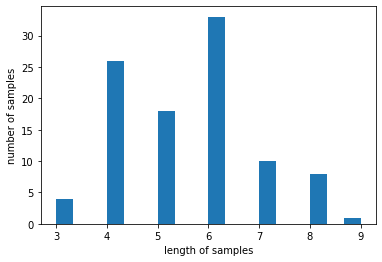

In [10]:
import matplotlib.pyplot as plt

# 문장별 어절 수 히스토그램
plt.hist([len(s) for s in word2id_list], bins=18)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# maxlen=10으로 앞부분 0으로 padding
max_len = 10
seqs = pad_sequences(seq_list, maxlen=max_len, padding='pre')

In [12]:
seqs[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 52], dtype=int32)

In [13]:
# train_test_split => 9:1
np.random.shuffle(seqs)
split_num = int(len(seqs) * 0.9)

X_train = seqs[:split_num,:-1]
y_train = seqs[:split_num,-1]
X_test = seqs[split_num:,:-1]
y_test = seqs[split_num:,-1]

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping()

model = Sequential()
model.add(Embedding(5000, 30, input_length=max_len-1, mask_zero=True)) 
model.add(GRU(128))
model.add(Dense(5000, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, y_train, validation_split=0.1, shuffle=True, epochs=100, batch_size=30, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 30)             150000    
                                                                 
 gru (GRU)                   (None, 128)               61440     
                                                                 
 dense (Dense)               (None, 5000)              645000    
                                                                 
Total params: 856,440
Trainable params: 856,440
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
15/15 [==============================] - 7s 109ms/step - loss: 8.4920 - accuracy: 0.1923 - val_loss: 8.4431 - val_accuracy: 0.1400
Epoch 2/100
15/15 [==============================] - 0s 32ms/step - loss: 8.2114 - accuracy: 0.1923 - val_loss: 7.7097 - val_accuracy: 0.1400
Epoch 3/100
15/15 [==========

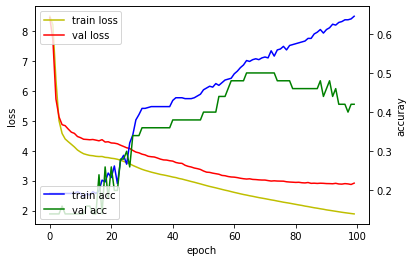

In [15]:
%matplotlib inline

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [16]:
loss_and_metrics = model.evaluate(X_test, y_test)

print('')
print('loss : ' + str(loss_and_metrics[0]))
print('accuray : ' + str(loss_and_metrics[1]))

2/2 [==============================] - 0s 13ms/step - loss: 3.5357 - accuracy: 0.5818

loss : 3.535738229751587
accuray : 0.581818163394928


In [28]:
init_word = '볼라드가'
cur_word = [init_word]
sentence = init_word
n = 10
for _ in range(n):
  encoded = [word2id[token] for token in cur_word]
  encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')
  result = np.argmax(model.predict(encoded))
  for word, id in word2id.items():
    if id == result:
      break
  cur_word += [word]
  sentence += ' ' + word
  if word == '<EOS>':
    break
sentence

'볼라드가 놓여 있고 사람이 걸어갑니다 <EOS>'

In [29]:
init_word = '자전거를'
cur_word = [init_word]
sentence = init_word
n = 10
for _ in range(n):
  encoded = [word2id[token] for token in cur_word]
  encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')
  result = np.argmax(model.predict(encoded))
  for word, id in word2id.items():
    if id == result:
      break
  cur_word += [word]
  sentence += ' ' + word
  if word == '<EOS>':
    break
sentence

'자전거를 탄 사람과 볼라드가 있습니다 <EOS>'

In [30]:
init_word = '자전거'
cur_word = [init_word]
sentence = init_word
n = 10
for _ in range(n):
  encoded = [word2id[token] for token in cur_word]
  encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')
  result = np.argmax(model.predict(encoded))
  for word, id in word2id.items():
    if id == result:
      break
  cur_word += [word]
  sentence += ' ' + word
  if word == '<EOS>':
    break
sentence

'자전거 여러 대와 사람이 있습니다 <EOS>'

In [33]:
init_word = '자전거'
cur_word = [init_word]
sentence = init_word
n = 3
for _ in range(n):
  encoded = [word2id[token] for token in cur_word]
  encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')
  result = np.argmax(model.predict(encoded))
  for word, id in word2id.items():
    if id == result:
      break
  cur_word += [word]
  sentence += ' ' + word
  if word == '<EOS>':
    break
sentence

'자전거 여러 대와 사람이'

In [34]:
cur_word = ['자전거와', '사람']
sentence = '자전거와 사람'
n = 10
for _ in range(n):
  encoded = [word2id[token] for token in cur_word]
  encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')
  result = np.argmax(model.predict(encoded))
  for word, id in word2id.items():
    if id == result:
      break
  cur_word += [word]
  sentence += ' ' + word
  if word == '<EOS>':
    break
sentence

'자전거와 사람 여러 대가 있습니다 <EOS>'

In [35]:
cur_word = ['자전거와', '사람이']
sentence = '자전거와 사람이'
n = 10
for _ in range(n):
  encoded = [word2id[token] for token in cur_word]
  encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')
  result = np.argmax(model.predict(encoded))
  for word, id in word2id.items():
    if id == result:
      break
  cur_word += [word]
  sentence += ' ' + word
  if word == '<EOS>':
    break
sentence

'자전거와 사람이 있습니다 <EOS>'